Take Raw LIGO O3b data, inject 30 seconds long signals

In [80]:
import numpy as np
import h5py
import os
import torch
import matplotlib.pyplot as plt

from tqdm import tqdm

from dataset import Spectrogram
from torch.utils.data import Dataset

In [81]:
num_data = 10000

duration = 8
sample_rate=2048

In [82]:
# Paths to data
data_path = '../data/'
in_path = data_path + 'raw/train/background/'
out_path = data_path+'chunks/'

train_data = os.listdir(in_path)
train_data = [data for data in train_data if data.endswith('.hdf5')]
print(train_data)

out_data = os.listdir(out_path)
[os.remove(out_path + file) for file in out_data]

['background-1241204831-9238.hdf5', 'background-1241002600-3101.hdf5', 'background-1241310397-20000.hdf5', 'background-1241113492-10318.hdf5', 'background-1240743328-5673.hdf5', 'background-1241263169-9449.hdf5', 'background-1240939428-1116.hdf5', 'background-1241163878-9945.hdf5', 'background-1241393338-4562.hdf5', 'background-1240940621-20000.hdf5', 'background-1240720690-14972.hdf5', 'background-1241123878-20000.hdf5', 'background-1241088652-3696.hdf5', 'background-1240784297-1811.hdf5', 'background-1240919428-20000.hdf5', 'background-1240624412-20000.hdf5', 'background-1240750849-12554.hdf5', 'background-1241417182-20000.hdf5', 'background-1241143878-20000.hdf5', 'background-1241243169-20000.hdf5', 'background-1240700690-20000.hdf5', 'background-1240795605-18638.hdf5', 'background-1241302060-7884.hdf5', 'background-1240892261-14732.hdf5', 'background-1241001309-1186.hdf5', 'background-1241068861-4928.hdf5', 'background-1240960621-590.hdf5', 'background-1240594562-12186.hdf5', 'back

[]

In [83]:
durations = np.array([int(i.split('-')[-1][:-5]) for i in train_data if i[0] != 's'])
chunks = durations//duration
chunks_per_file = (chunks*num_data*1.1//sum(chunks)).astype(int)

In [84]:
param_dict = ["chirp_mass", "mass_ratio", "chi1", "chi2", "distance", "phic", "inclination", 'dec', 'phi', 'psi', 'snr']

100%|█████████████████████████████████████████████| 1/1 [00:14<00:00, 14.85s/it]


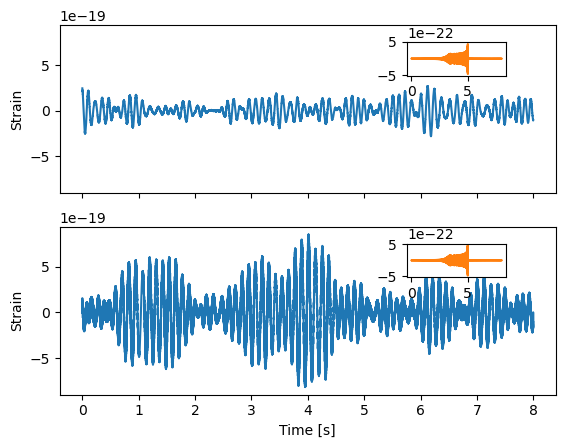

In [85]:
from Waveform import new_hphc
from ml4gw.transforms import SpectralDensity
from ml4gw.distributions import PowerLaw, Sine, Cosine, DeltaFunction
from torch.distributions import Uniform

device='cpu'

fftlength = 2
spectral_density = SpectralDensity(
    sample_rate=sample_rate,
    fftlength=fftlength,
    overlap=None,
    average="median",
).to(device)

index_len = duration*sample_rate

fig, ax = plt.subplots(2, sharex=True, sharey=True)

for i in tqdm(range(1)):#range(len(train_data))):

    data = h5py.File(in_path + train_data[i])
    H1 = np.array(data['H1'])
    L1 = np.array(data['L1'])

    ## get psd

    background = torch.stack([torch.from_numpy(H1), torch.from_numpy(L1)])
    psd = spectral_density(background.double())

    
    num_chunks = chunks_per_file[i]
    length = durations[i]
    ranges = np.linspace(0, length, num_chunks+1)
    times = [np.random.randint(ranges[i], ranges[i+1]-duration, 1)[0] for i in range(num_chunks)]

    waveforms = []
    parameters = {k: torch.tensor([]) for k in param_dict}

    ln = 0
    while ln < num_chunks:
        waveform, parameter, h1_snr, l1_snr = new_hphc(1, psd=psd)

        if h1_snr > 13 and l1_snr > 13:
            waveforms.append(waveform[0])

            for k, v in parameter.items():
                parameters[k] = torch.cat((parameters[k], v), dim=0)
            
            ln += 1
        

    #waveforms, parameters = new_hphc(1, psd=psd)
    waveforms = torch.stack(waveforms)

    
    
    h1 = (waveforms[:, 0]).numpy()  ## need to be projected using compute_observed_strain. Float Error
    l1 = (waveforms[:, 1]).numpy() ## Right now, I am using polarizations as projections which is wrong

    H = []
    L = []

    for j in range(1):#num_chunks):

        index = int(times[j]*sample_rate)
        H_chunk = H1[index: int(index + index_len)]  ## needs same filtering as the waveforms
        L_chunk = L1[index: int(index + index_len)]

        time = np.linspace(0, 8, 2048*8)
        
        ax[0].plot(time, H_chunk)
        inset = ax[0].inset_axes([0.7,0.7,0.2,0.2])
        inset.plot(time, h1[j], c='C1')
        inset.set_yticks([-5*10**(-22), 5*10**(-22)])

        ax[1].plot(time, L_chunk)
        inset = ax[1].inset_axes([0.7,0.7,0.2,0.2])
        inset.plot(time, l1[j], c='C1')
        inset.set_yticks([-5*10**(-22), 5*10**(-22)])

        ax[1].set_xlabel('Time [s]')
        ax[0].set_ylabel('Strain')
        ax[1].set_ylabel('Strain')

        H_chunk = H_chunk + h1[j]
        L_chunk = L_chunk + l1[j]

        H.append(H_chunk)
        L.append(L_chunk)

    H = np.vstack(H)
    L = np.vstack(L)

    

    '''
    out = h5py.File(out_path+train_data[i], 'w')
    out.create_dataset('H1', data=H)
    out.create_dataset('L1', data=L)

    for k, v in parameters.items():
        out.create_dataset(k, data=v)

    out.close()
    '''

In [86]:
H_chunk.shape

(16384,)

In [87]:
batch = np.array([[H_chunk], [L_chunk]])
waveform = np.array([[h1[j]], [l1[j]]])

batch.shape

(2, 1, 16384)

In [88]:
spec = Spectrogram(num_points=batch.shape[-1])

whitened_data = spec.whitening(batch)
whiten_injection = spec.whitening(waveform, fit_batch=batch)
whitened_data.shape, whiten_injection.shape

(torch.Size([1, 2, 14336]), torch.Size([1, 2, 14336]))

Text(0.5, 0, 'Time [s]')

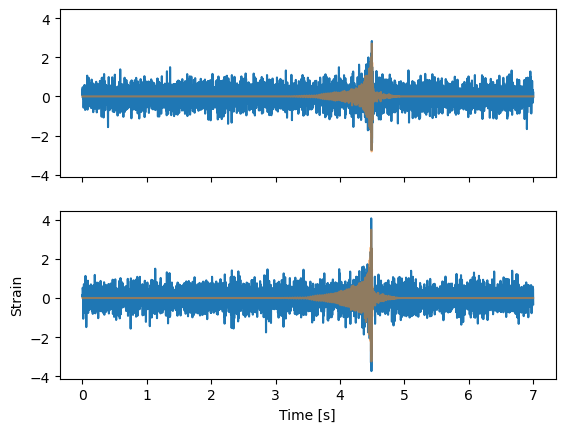

In [93]:
fig, ax = plt.subplots(2, sharex=True, sharey=True)

time = np.linspace(0, whitened_data.shape[-1]//2048, whitened_data.shape[-1])
ax[0].plot(time, whitened_data[0, 0])
ax[1].plot(time, whitened_data[0, 1])
ax[0].plot(time, whiten_injection[0, 0], alpha=0.5)
ax[1].plot(time, whiten_injection[0, 1], alpha=0.5)

#ax[1].set_xlabel('Time [s]')
ax[1].set_ylabel('Strain')
ax[1].set_xlabel('Time [s]')
#ax[1].set_ylabel('Strain')

In [65]:
jittered_data = spec.jitter(whitened_data[0], [])[0]
jittered_data.shape

(10, 2, 12288)

Text(0, 0.5, 'Strain')

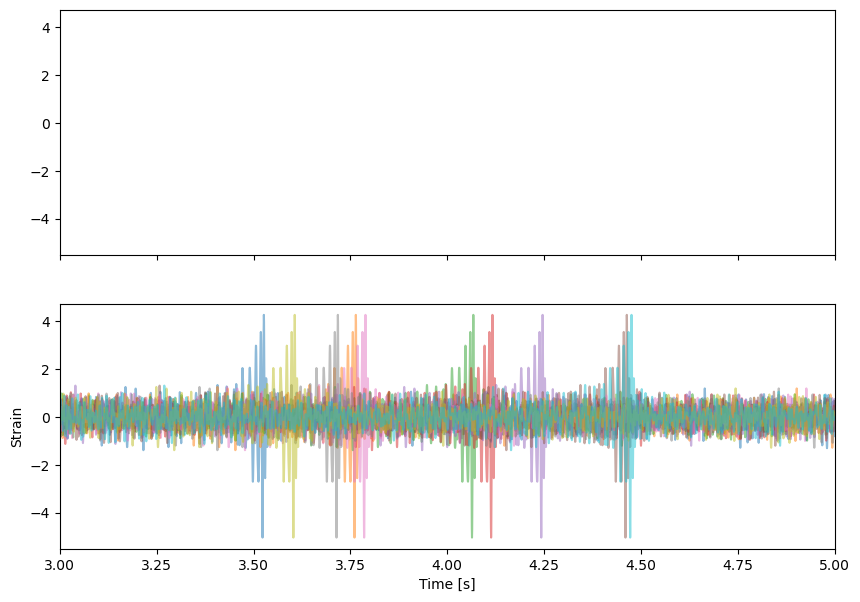

In [96]:
time = np.linspace(0, jittered_data.shape[-1]//2048, jittered_data.shape[-1])

fig, ax = plt.subplots(2, sharex=True, sharey=True, figsize=(10, 7))

for i in range(10):
    ax[1].plot(time, jittered_data[i, 0], alpha=0.5)

#ax[-1].set_xlim([3, 5])

ax[-1].set_xlabel('Time [s]')
ax[-1].set_xlim(3, 5)
ax[-1].set_ylabel('Strain')

Text(0, 0.5, 'Strain')

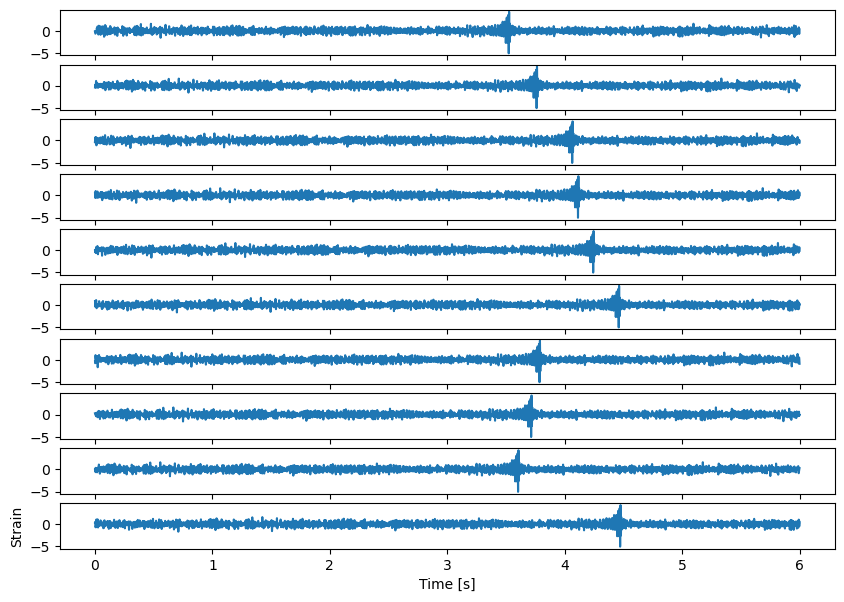

In [66]:
time = np.linspace(0, jittered_data.shape[-1]//2048, jittered_data.shape[-1])

fig, ax = plt.subplots(10, sharex=True, sharey=True, figsize=(10, 7))

for i in range(10):
    ax[i].plot(time, jittered_data[i, 0])

#ax[-1].set_xlim([3, 5])

ax[-1].set_xlabel('Time [s]')
ax[-1].set_ylabel('Strain')


In [67]:
spectrograms = spec.spect(jittered_data)

In [68]:
spectrograms.shape

torch.Size([10, 2, 80, 205])

Text(0, 0.5, 'Frequency [Hz]')

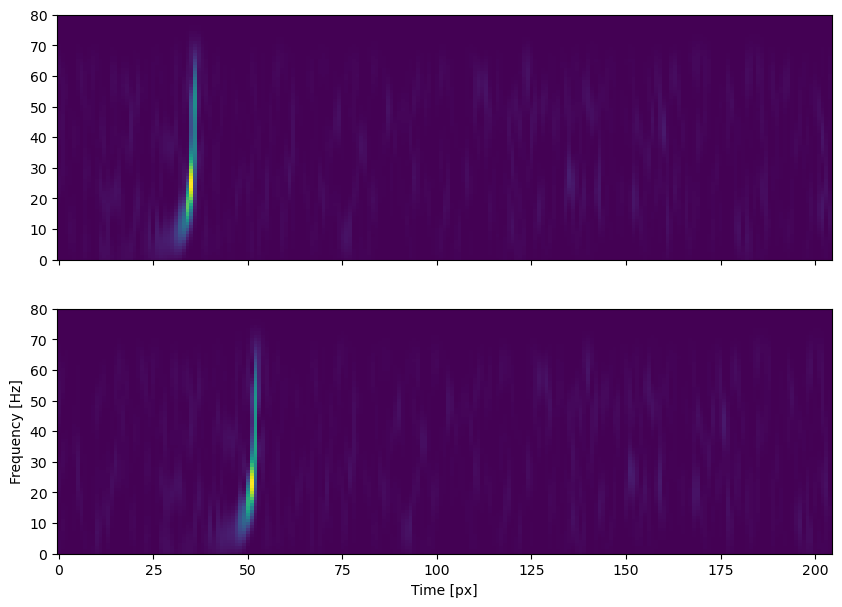

In [98]:
fig, ax = plt.subplots(2, sharex=True, sharey=True, figsize=(10, 7))

for i in range(2):
    ax[i].imshow(spectrograms[i, 0, :, :], aspect='auto', cmap='viridis')

ax[i].set_ylim(80, 0)
ax[i].invert_yaxis()

ax[-1].set_xlabel('Time [px]')

ax[-1].set_ylabel('Frequency [Hz]')